# Flower Classification using CNN Models

We recovered Phil Cullington's notebook using TPU to make Flower Classification.  
Value of initial accuracy : ~0.35

# Getting libraries

In [1]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np
import math
import matplotlib.pyplot as plt

print("Tensorflow version " + tf.__version__)
!pip install efficientnet
import efficientnet.tfkeras as efficientnet

Tensorflow version 2.6.4


# Detect my accelerator

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = (
        tf.distribute.cluster_resolver.TPUClusterResolver()
    )  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print("Running on TPU ", tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = (
        tf.distribute.get_strategy()
    )  # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Data path
### Look on work folders

In [3]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path(
    "tpu-getting-started"
)  # you can list the bucket with "!gsutil ls $GCS_DS_PATH"
# GCS_DS_PATH
!gsutil ls $GCS_DS_PATH

gs://kds-01818b8ed331d485bb6c680594eca0710ffee819c40c0c0111aedb9a/sample_submission.csv
gs://kds-01818b8ed331d485bb6c680594eca0710ffee819c40c0c0111aedb9a/tfrecords-jpeg-192x192/
gs://kds-01818b8ed331d485bb6c680594eca0710ffee819c40c0c0111aedb9a/tfrecords-jpeg-224x224/
gs://kds-01818b8ed331d485bb6c680594eca0710ffee819c40c0c0111aedb9a/tfrecords-jpeg-331x331/
gs://kds-01818b8ed331d485bb6c680594eca0710ffee819c40c0c0111aedb9a/tfrecords-jpeg-512x512/


# Set parameters

In [4]:
size = 224
IMAGE_SIZE = [size, size]  # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 30
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
AUTO = tf.data.AUTOTUNE

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

# Define classes name

In [5]:
CLASSES = [
    "pink primrose",
    "hard-leaved pocket orchid",
    "canterbury bells",
    "sweet pea",
    "wild geranium",
    "tiger lily",
    "moon orchid",
    "bird of paradise",
    "monkshood",
    "globe thistle",  # 00 - 09
    "snapdragon",
    "colt's foot",
    "king protea",
    "spear thistle",
    "yellow iris",
    "globe-flower",
    "purple coneflower",
    "peruvian lily",
    "balloon flower",
    "giant white arum lily",  # 10 - 19
    "fire lily",
    "pincushion flower",
    "fritillary",
    "red ginger",
    "grape hyacinth",
    "corn poppy",
    "prince of wales feathers",
    "stemless gentian",
    "artichoke",
    "sweet william",  # 20 - 29
    "carnation",
    "garden phlox",
    "love in the mist",
    "cosmos",
    "alpine sea holly",
    "ruby-lipped cattleya",
    "cape flower",
    "great masterwort",
    "siam tulip",
    "lenten rose",  # 30 - 39
    "barberton daisy",
    "daffodil",
    "sword lily",
    "poinsettia",
    "bolero deep blue",
    "wallflower",
    "marigold",
    "buttercup",
    "daisy",
    "common dandelion",  # 40 - 49
    "petunia",
    "wild pansy",
    "primula",
    "sunflower",
    "lilac hibiscus",
    "bishop of llandaff",
    "gaura",
    "geranium",
    "orange dahlia",
    "pink-yellow dahlia",  # 50 - 59
    "cautleya spicata",
    "japanese anemone",
    "black-eyed susan",
    "silverbush",
    "californian poppy",
    "osteospermum",
    "spring crocus",
    "iris",
    "windflower",
    "tree poppy",  # 60 - 69
    "gazania",
    "azalea",
    "water lily",
    "rose",
    "thorn apple",
    "morning glory",
    "passion flower",
    "lotus",
    "toad lily",
    "anthurium",  # 70 - 79
    "frangipani",
    "clematis",
    "hibiscus",
    "columbine",
    "desert-rose",
    "tree mallow",
    "magnolia",
    "cyclamen ",
    "watercress",
    "canna lily",  # 80 - 89
    "hippeastrum ",
    "bee balm",
    "pink quill",
    "foxglove",
    "bougainvillea",
    "camellia",
    "mallow",
    "mexican petunia",
    "bromelia",
    "blanket flower",  # 90 - 99
    "trumpet creeper",
    "blackberry lily",
    "common tulip",
    "wild rose",
]

 # Functions space

In [8]:
### Decoding image
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])  # explicit size needed for TPU
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = tf.cast(example["class"], tf.int32)
    return image, label  # returns a dataset of (image, label) pairs


def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    idnum = example["id"]
    return image, idnum  # returns a dataset of image(s)


### Data augmentation function
#### Horizontal and vertical mirorring
#### Random cropping
#### Random rotation
#### Saturation, brightness and contrast can be modified randomly too


def data_augment(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_crop(x, size = [size,size,3])
    #p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    # if p_rotate > .8:
    #    x = tf.image.rot90(x, k=3)
    # elif p_rotate > .6:
    #    x = tf.image.rot90(x, k=2)
    # elif p_rotate > .4:
    #    x = tf.image.rot90(x, k=1)
    x = tf.image.random_saturation(x,0.5,2)
    #x = tf.image.random_brightness(x, 2)
    x = tf.image.random_contrast(x,0.8,1.2)
    return x, y


### Loading data
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    return dataset


### Getting training, validation and test dataset
def get_training_dataset():
    dataset = load_dataset(
        tf.io.gfile.glob(GCS_DS_PATH + "/tfrecords-jpeg-224x224/train/*.tfrec"),
        labeled=True,
    )
    dataset = dataset.repeat()  # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset


def get_validation_dataset():
    dataset = load_dataset(
        tf.io.gfile.glob(GCS_DS_PATH + "/tfrecords-jpeg-224x224/val/*.tfrec"),
        labeled=True,
        ordered=False,
    )
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset


def get_test_dataset(ordered=False):
    dataset = load_dataset(
        tf.io.gfile.glob(GCS_DS_PATH + "/tfrecords-jpeg-224x224/test/*.tfrec"),
        labeled=False,
        ordered=ordered,
    )
    dataset = dataset.batch(BATCH_SIZE)
    return dataset


training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()


def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object:  # binary string in this case,
        # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels


def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = label == correct_label
    return (
        "{} [{}{}{}]".format(
            CLASSES[label],
            "OK" if correct else "NO",
            "\u2192" if not correct else "",
            CLASSES[correct_label] if not correct else "",
        ),
        correct,
    )


def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis("off")
    plt.imshow(image)
    if len(title) > 0:
        plt.title(
            title,
            fontsize=int(titlesize) if not red else int(titlesize / 1.2),
            color="red" if red else "black",
            fontdict={"verticalalignment": "center"},
            pad=int(titlesize / 1.5),
        )
    return (subplot[0], subplot[1], subplot[2] + 1)


def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE / cols * rows))
    else:
        plt.figure(figsize=(FIGSIZE / rows * cols, FIGSIZE))

    # display
    for i, (image, label) in enumerate(
        zip(images[: rows * cols], labels[: rows * cols])
    ):
        title = "" if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = (
            FIGSIZE * SPACING / max(rows, cols) * 40 + 3
        )  # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(
            image, title, subplot, not correct, titlesize=dynamic_titlesize
        )

    # layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


### Defining the evolution of loss parameter
def lr_function(epoch):
    start_lr = 1e-3
    min_lr = 1e-5
    max_lr = 1e-3
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = 0.8

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr) / rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:  # E
            lr = (max_lr - min_lr) * exp_decay ** (
                epoch - rampup_epochs - sustain_epochs
            ) + min_lr
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)


callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                 patience=5,
    #                                 restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: lr_function(epoch), verbose=True  # B
    )
]

### Define function to display results
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor="#F0F0F0")
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor("#F8F8F8")
    ax.plot(training)
    ax.plot(validation)
    ax.set_title("model " + title)
    ax.set_ylabel(title)
    ax.set_xlabel("epoch")
    ax.legend(["train ", "valid"])

# Visualize Data

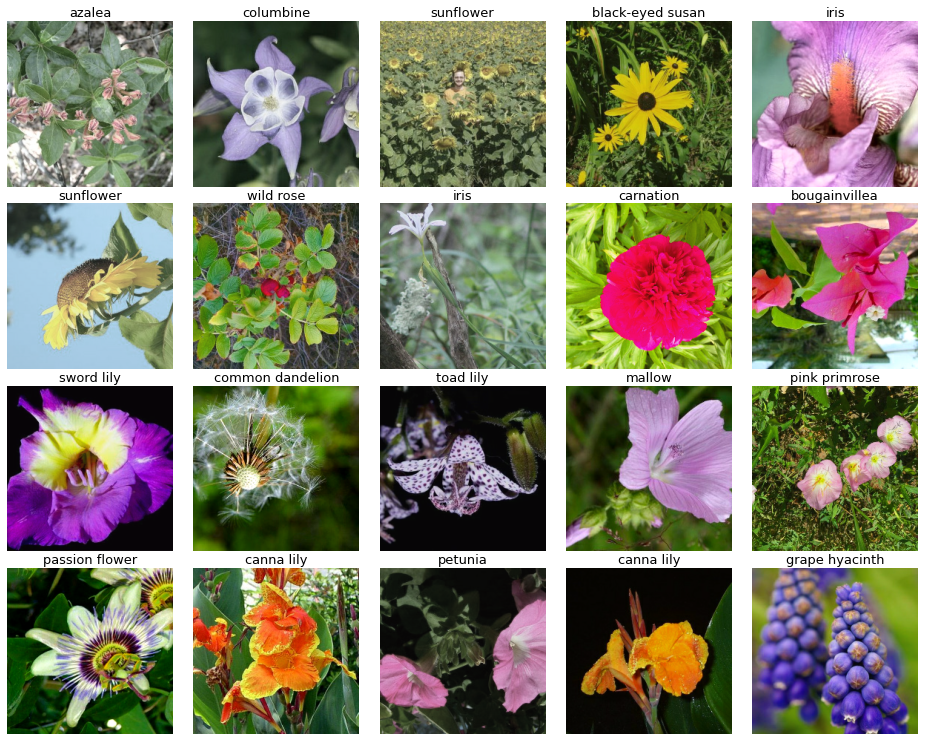

In [9]:
ds_train = get_training_dataset()
ds_iter = iter(ds_train.unbatch().batch(20))
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

# Models

# DenseNet201

In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.


2022-10-26 17:49:41.617534: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1594/1594 [==============================] - 270s 150ms/step - loss: 4.0035 - sparse_categorical_accuracy: 0.1030 - val_loss: 781.0283 - val_sparse_categorical_accuracy: 0.0180
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1594/1594 [==============================] - 223s 140ms/step - loss: 3.4630 - sparse_categorical_accuracy: 0.1600 - val_loss: 17.6546 - val_sparse_categorical_accuracy: 0.1910
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1594/1594 [==============================] - 222s 139ms/step - loss: 3.0970 - sparse_categorical_accuracy: 0.2181 - val_loss: 2.8868 - val_sparse_categorical_accuracy: 0.2575
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1594/1594 [==============================] - 220s 138ms/step - loss: 2.7830 - sparse_categorical_accuracy: 0.2800 - val_loss: 2.6681 - val_sparse_categorical_accuracy: 0.3419
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learn

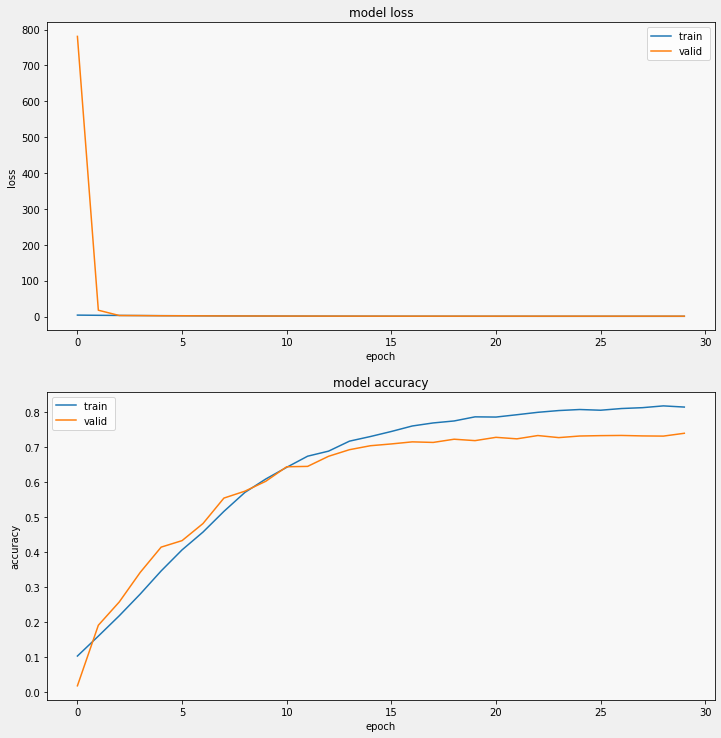

In [10]:
%%time
with strategy.scope():
    pretrained_model = tf.keras.applications.DenseNet201(
        weights="imagenet", include_top=False, input_shape=(size, size, 3)
    )
    pretrained_model.trainable = True  # transfer learning

    model = tf.keras.Sequential(
        [
            pretrained_model,
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.GlobalAveragePooling2D(),
            # tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(104, activation="softmax"),
        ]
    )

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

historical = model.fit(
    training_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

display_training_curves(
    historical.history["loss"],
    historical.history["val_loss"],
    "loss",
    211,
)

display_training_curves(
    historical.history["sparse_categorical_accuracy"],
    historical.history["val_sparse_categorical_accuracy"],
    "accuracy",
    212,
)

# RESNET

In [ ]:
with strategy.scope():
    pretrained_model = tf.keras.applications.ResNet152V2(
        weights="imagenet", include_top=False, input_shape=(512, 512, 3)
    )
    pretrained_model.trainable = True  # transfer learning

    model = tf.keras.Sequential(
        [
            pretrained_model,
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.GlobalAveragePooling2D(),
            # tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(104, activation="softmax"),
        ]
    )

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

historical = model.fit(
    training_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

display_training_curves(
    historical.history["loss"],
    historical.history["val_loss"],
    "loss",
    211,
)

display_training_curves(
    historical.history["sparse_categorical_accuracy"],
    historical.history["val_sparse_categorical_accuracy"],
    "accuracy",
    212,
)

# Xception

In [ ]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(
        weights="imagenet", include_top=False, input_shape=(512, 512, 3)
    )
    pretrained_model.trainable = True  # transfer learning

    model = tf.keras.Sequential(
        [
            pretrained_model,
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.GlobalAveragePooling2D(),
            # tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(104, activation="softmax"),
        ]
    )

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

historical = model.fit(
    training_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

display_training_curves(
    historical.history["loss"],
    historical.history["val_loss"],
    "loss",
    211,
)

display_training_curves(
    historical.history["sparse_categorical_accuracy"],
    historical.history["val_sparse_categorical_accuracy"],
    "accuracy",
    212,
)

with strategy.scope():    
    pretrained_model = efficientnet.EfficientNetB7(weights='noisy-student', 
                                                         include_top=False ,
                                                         input_shape=(512,512,3))
    pretrained_model.trainable = True # tramsfer learning

# EfficientNetV2XL

This model has been downloaded from this link : https://github.com/leondgarse/keras_cv_attention_models
The tensorflow's version on kaggle is not sufficiently updated to get this model via keras.applications, we thus get it, and load it using load_model function.

In [ ]:
with strategy.scope():
    modelv2xl = tf.keras.models.load_model(
        "/kaggle/input/effnetv2xl/efficientnetv2-xl-21k-ft1k.h5", compile=True
    )
    modelv2xl.trainable = False
    model = tf.keras.Sequential(
        [
            modelv2xl,
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            # tf.keras.layers.Reshape((10,10,10)),
            # tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(104, activation="softmax"),
        ]
    )
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

historical = model.fit(
    training_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

display_training_curves(
    historical.history["loss"],
    historical.history["val_loss"],
    "loss",
    211,
)

display_training_curves(
    historical.history["sparse_categorical_accuracy"],
    historical.history["val_sparse_categorical_accuracy"],
    "accuracy",
    212,
)

# EfficientNetB7

In [ ]:
with strategy.scope():
    pretrained_model = efficientnet.EfficientNetB7(
        weights="noisy-student", include_top=False, input_shape=(512, 512, 3)
    )
    pretrained_model.trainable = True  # transfer learning

    model = tf.keras.Sequential(
        [
            pretrained_model,
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(104, activation="softmax"),
        ]
    )
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

historical = model.fit(
    training_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

display_training_curves(
    historical.history["loss"],
    historical.history["val_loss"],
    "loss",
    211,
)

display_training_curves(
    historical.history["sparse_categorical_accuracy"],
    historical.history["val_sparse_categorical_accuracy"],
    "accuracy",
    212,
)

# EfficientNetV2L

In [ ]:
with strategy.scope():
    modelv2xl = tf.keras.models.load_model(
        "/kaggle/input/effnetv2l/efficientnetv2-l-imagenet.h5", compile=True
    )
    modelv2xl.trainable = False
    model = tf.keras.Sequential(
        [
            modelv2xl,
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.2),
            # tf.keras.layers.Reshape((10,10,10)),
            # tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(104, activation="softmax"),
        ]
    )
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

historical = model.fit(
    training_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

display_training_curves(
    historical.history["loss"],
    historical.history["val_loss"],
    "loss",
    211,
)

display_training_curves(
    historical.history["sparse_categorical_accuracy"],
    historical.history["val_sparse_categorical_accuracy"],
    "accuracy",
    212,
)

# Predictions

This will create a file that can be submitted to the competition.

In [ ]:
test_ds = get_test_dataset(
    ordered=True
)  # since we are splitting the dataset and iterating separately on images and ids, order matters.

print("Computing predictions...")
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print("Generating submission.csv file...")
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = (
    next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype("U")
)  # all in one batch
np.savetxt(
    "submission.csv",
    np.rec.fromarrays([test_ids, predictions]),
    fmt=["%s", "%d"],
    delimiter=",",
    header="id,label",
    comments="",
)